## 1. Project Overview

This notebook demonstrates the design and implementation of a Multi-Agent Reinforcement Learning system for an extended 3-player Tic-Tac-Toe game.
- Board Size: 5x5
- Players: X (Human), O (Agent 1), △ (Agent 2)
- Win Condition: 4 in a row
- Custom rules and constraints are implemented to enhance strategy and challenge.

---

## 2. Game Rules & Constraints

- **Power Move**: Each player may play twice in one turn, only once per game.
- **Swap Move**: Undo the last move (one-time use).
- **Blocked Cells**: 2–3 randomly blocked cells at game start.
- **Bonus/Trap Zones**: +5 bonus or -3 penalty on certain random cells.
- **Tracking**: Game state tracks move history, power/swap usage, and zone rewards.

In [1]:
# 🧠 Core Libraries
import random
import numpy as np
import copy


---

## 3. Environment Definition

This section defines the custom environment `TicTacToeEnv`, with state representation, move validation, reward calculation, and turn rotation logic.

In [37]:
import random

class TicTacToeEnv:
    def __init__(self):
        self.players = ['X', 'O', '△']
        self.board_size = 5
        self.win_length = 4
        self.reset()

    def reset(self):
        self.board = [[' ' for _ in range(self.board_size)] for _ in range(self.board_size)]
        self.done = False
        self.winner = None
        self.current_player_index = 0
        self.turns = 0

        # Random blocked cells
        all_cells = [(i, j) for i in range(self.board_size) for j in range(self.board_size)]
        self.blocked_cells = random.sample(all_cells, 3)

        # Bonus and trap cells
        remaining_cells = list(set(all_cells) - set(self.blocked_cells))
        self.bonus_cells = random.sample(remaining_cells, 3)
        remaining_cells = list(set(remaining_cells) - set(self.bonus_cells))
        self.trap_cells = random.sample(remaining_cells, 2)

        # Track player state
        self.player_info = {
            'X': {'power_used': False, 'swap_used': False, 'last_move': None, 'bonus_cells_collected': [], 'trap_cells_hit': []},
            'O': {'power_used': False, 'swap_used': False, 'last_move': None, 'bonus_cells_collected': [], 'trap_cells_hit': []},
            '△': {'power_used': False, 'swap_used': False, 'last_move': None, 'bonus_cells_collected': [], 'trap_cells_hit': []}
        }

        # VISUAL MARKING: Set '*' on blocked cells
        for (r, c) in self.blocked_cells:
            self.board[r][c] = '*'

        return self.get_state()

    def get_state(self):
        return [row.copy() for row in self.board]  # return a deep copy of the board

    def check_winner(self, row, col, player):
        directions = [(-1, 0), (1, 0),   # vertical
                      (0, -1), (0, 1),   # horizontal
                      (-1, -1), (1, 1),  # diagonal ↘
                      (-1, 1), (1, -1)]  # diagonal ↙

        for dr, dc in directions:
            count = 1
            # Check one direction
            r, c = row + dr, col + dc
            while 0 <= r < self.board_size and 0 <= c < self.board_size and self.board[r][c] == player:
                count += 1
                r += dr
                c += dc

            # Check opposite direction
            r, c = row - dr, col - dc
            while 0 <= r < self.board_size and 0 <= c < self.board_size and self.board[r][c] == player:
                count += 1
                r -= dr
                c -= dc

            if count >= self.win_length:
                return True
        return False

    def step(self, action, use_power=False, use_swap=False):
        if self.done:
            return self.get_state(), 0, True, {"reason": "Game is over"}

        row, col = action
        player = self.players[self.current_player_index]

        # Check if cell is valid
        if (row, col) in self.blocked_cells or not (0 <= row < self.board_size) or not (0 <= col < self.board_size):
            return self.get_state(), -10, False, {"reason": "Invalid or blocked cell"}

        # Swap logic
        if use_swap:
            if self.player_info[player]['swap_used'] or self.player_info[player]['last_move'] is None:
                return self.get_state(), -5, False, {"reason": "Swap already used or no move to swap"}
            last_row, last_col = self.player_info[player]['last_move']
            self.board[last_row][last_col] = ' '
            self.player_info[player]['swap_used'] = True
            return self.get_state(), 1, False, {"action": "Swapped own move"}

        # Check if cell already filled
        if self.board[row][col] != ' ':
            return self.get_state(), -5, False, {"reason": "Cell already filled"}

        # Place mark
        self.board[row][col] = player
        self.player_info[player]['last_move'] = (row, col)

        # Bonus/trap cell logic
        reward = 0
        if (row, col) in self.bonus_cells:
            reward += 5
            self.player_info[player]['bonus_cells_collected'].append((row, col))
        elif (row, col) in self.trap_cells:
            reward -= 3
            self.player_info[player]['trap_cells_hit'].append((row, col))

        # Power move logic
        if use_power:
            if self.player_info[player]['power_used']:
                return self.get_state(), -5, False, {"reason": "Power move already used"}
            self.player_info[player]['power_used'] = True
            return self.get_state(), reward + 1, False, {"action": "Used power move: Place another mark"}

        # Check for win
        if self.check_winner(row, col, player):
            self.done = True
            self.winner = player
            return self.get_state(), reward + 10, True, {"winner": player}

        # Count turns (only if move was successful)
        self.turns += 1

        # Draw condition based on turn limit
        if self.turns >= 25:
            self.done = True
            return self.get_state(), reward, True, {"winner": None}

        # ✅ New: Fallback - Check if no empty cells remain
        empty_cells = sum(row.count(' ') for row in self.board)
        if empty_cells == 0:
            self.done = True
            return self.get_state(), reward, True, {"winner": None}

        # Continue to next player
        self.current_player_index = (self.current_player_index + 1) % len(self.players)
        return self.get_state(), reward, False, {"action": "Standard move"}



In [38]:
env = TicTacToeEnv()
env.reset()

# Pre-fill 3 marks for 'X' on the board
env.board[0][0] = 'X'
env.board[0][1] = 'X'
env.board[0][2] = 'X'

# Set the current player index to match 'X'
env.current_player_index = 0

# Now make the winning move
state, reward, done, info = env.step((0, 3))

# Output results
for row in state:
    print(row)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)


['X', 'X', 'X', 'X', ' ']
[' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', '*', ' ']
[' ', '*', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ']
Reward: 10
Done: True
Info: {'winner': 'X'}


In [39]:
env = TicTacToeEnv()
env.reset()

# Try placing a move
state, reward, done, info = env.step((1, 2))
print(f"Reward: {reward}, Done: {done}, Info: {info}")

# Try a blocked move
state, reward, done, info = env.step(env.blocked_cells[0])
print(f"Reward: {reward}, Done: {done}, Info: {info}")


Reward: 0, Done: False, Info: {'action': 'Standard move'}
Reward: -10, Done: False, Info: {'reason': 'Invalid or blocked cell'}


---

## 4. Q-Learning Algorithm

Initial implementation of Q-Learning used a Q-table and followed the Bellman update:
$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s,a)\right] $$
Where α is the learning rate, γ is the discount factor.

## 5. Deep Q-Network (DQN)

We implemented a neural network-based agent:
- Input: Flattened board state (25 dimensions)
- Output: Q-values for all actions
- Architecture: Linear layers with ReLU
- Loss Function: MSE between predicted and target Q-values.

* 5.1 Code: State Encoder

In [41]:
import numpy as np

def encode_state(board):
    encoding = {
        ' ': 0,
        'X': 1,
        'O': 2,
        '△': 3,
        '*': -1
    }
    flat_encoded = [encoding[cell] for row in board for cell in row]
    return np.array(flat_encoded, dtype=np.float32)


In [42]:
env = TicTacToeEnv()
state = env.reset()

encoded = encode_state(state)
print("Encoded shape:", encoded.shape)
print(encoded.reshape(5, 5))


Encoded shape: (25,)
[[ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.]]


* 5.2: Build the DQN Model (PyTorch)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=128, output_dim=25):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)  # Q-values for each action


In [44]:
model = DQN()
dummy_input = torch.tensor(encode_state(env.reset())).unsqueeze(0)  # shape: [1, 25]
output = model(dummy_input)
print("Output shape:", output.shape)
print(output)


Output shape: torch.Size([1, 25])
tensor([[-0.0412, -0.0222,  0.1205,  0.1009,  0.0443,  0.0180,  0.1137,  0.0151,
          0.0238, -0.0496, -0.0258,  0.0074, -0.0159,  0.0876, -0.0103, -0.0378,
          0.0429, -0.1058,  0.0883,  0.1399,  0.0420, -0.0187, -0.1360,  0.0807,
          0.0580]], grad_fn=<AddmmBackward0>)


* 5.3 – Build the Replay Buffer

In [45]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Save as tuples
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Randomly sample a batch
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buffer)


In [46]:
rb = ReplayBuffer(capacity=1000)

# Push a few dummy transitions
s1 = encode_state(env.reset())
s2 = encode_state(env.reset())
rb.push(s1, 3, 1.0, s2, False)

print("Buffer size:", len(rb))
sampled = rb.sample(1)
print("Sample shape:", [x.shape for x in sampled])


Buffer size: 1
Sample shape: [(1, 25), (1,), (1,), (1, 25), (1,)]


* 5.4: Training Loop (Core DQN Engine - epsilon-greedy, optimizer, target update)
& Training Pipeline

    - Epsilon-Greedy Strategy for exploration vs exploitation
    - Replay buffer stores past transitions
    - Trained for 1500 episodes using PyTorch
    - Target: Maximize total reward and improve win rate

In [54]:
def train_dqn(env, model, buffer, episodes=500, batch_size=64, gamma=0.99, 
              epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epsilon = epsilon_start
    all_rewards = []
    all_outcomes = []  # List to store "win" or "draw" for each episode
    
    for episode in range(episodes):
        state = encode_state(env.reset())
        total_reward = 0
        done = False
        outcome = None  # Will be set to "win" or "draw" at the end
        
        while not done:
            # Get list of valid actions: only empty cells (' ')
            valid_actions = [i for i in range(25) if env.board[i // 5][i % 5] == ' ']
            if not valid_actions:
                break  # No available move

            # ε-greedy action selection from valid actions only
            if random.random() < epsilon:
                action = random.choice(valid_actions)
            else:
                with torch.no_grad():
                    q_values = model(torch.tensor(state).unsqueeze(0))
                    action = max(valid_actions, key=lambda a: q_values[0][a].item())
                    
            # Convert action number into board coordinates
            row, col = divmod(action, env.board_size)
            
            next_state_raw, reward, done, info = env.step((row, col))
            next_state = encode_state(next_state_raw)
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Train the model once we have enough samples in the replay buffer
            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)

                states = torch.tensor(states)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards)
                next_states = torch.tensor(next_states)
                dones = torch.tensor(dones)

                q_values = model(states)
                next_q_values = model(next_states).detach()

                target_q = rewards + gamma * next_q_values.max(1)[0] * (1 - dones)
                predicted_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()

                loss = F.mse_loss(predicted_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Determine outcome based on info in the last step
        if "winner" in info and info["winner"]:
            outcome = "win"
        else:
            outcome = "draw"

        all_rewards.append(total_reward)
        all_outcomes.append(outcome)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f} | Outcome: {outcome}")

    return all_rewards, all_outcomes


In [58]:
env = TicTacToeEnv()
model = DQN()
buffer = ReplayBuffer()

all_rewards, all_outcomes = train_dqn(env, model, buffer, episodes=1500)


Episode 50/1500 | Reward: 19.00 | Epsilon: 0.778 | Outcome: win
Episode 100/1500 | Reward: 9.00 | Epsilon: 0.606 | Outcome: draw
Episode 150/1500 | Reward: 14.00 | Epsilon: 0.471 | Outcome: win
Episode 200/1500 | Reward: 9.00 | Epsilon: 0.367 | Outcome: draw
Episode 250/1500 | Reward: 9.00 | Epsilon: 0.286 | Outcome: draw
Episode 300/1500 | Reward: 9.00 | Epsilon: 0.222 | Outcome: draw
Episode 350/1500 | Reward: 9.00 | Epsilon: 0.173 | Outcome: draw
Episode 400/1500 | Reward: 9.00 | Epsilon: 0.135 | Outcome: draw
Episode 450/1500 | Reward: 9.00 | Epsilon: 0.105 | Outcome: draw
Episode 500/1500 | Reward: 9.00 | Epsilon: 0.100 | Outcome: draw
Episode 550/1500 | Reward: 19.00 | Epsilon: 0.100 | Outcome: win
Episode 600/1500 | Reward: 9.00 | Epsilon: 0.100 | Outcome: draw
Episode 650/1500 | Reward: 9.00 | Epsilon: 0.100 | Outcome: draw
Episode 700/1500 | Reward: 9.00 | Epsilon: 0.100 | Outcome: draw
Episode 750/1500 | Reward: 9.00 | Epsilon: 0.100 | Outcome: draw
Episode 800/1500 | Reward:

---

## 6. Visualization: Win & Draw Performance Over Training

This plot tracks the agent's performance over time by visualizing the percentage of episodes that resulted in a **win** or a **draw**.

### How it works:
- Takes a list of game outcomes per episode: `"win"`, `"draw"`, or other.
- Converts them into binary counters.
- Calculates the cumulative percentage of wins and draws.
- Plots both percentages as training progresses.

This helps evaluate the **agent's learning curve** and its tendency toward optimal or conservative play.


In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_win_draw(outcomes):
    episodes = np.arange(1, len(outcomes)+1)
    # Convert outcomes to binary arrays: win -> 1, draw -> 0
    wins = np.array([1 if outcome == "win" else 0 for outcome in outcomes])
    draws = np.array([1 if outcome == "draw" else 0 for outcome in outcomes])
    
    # Compute cumulative percentage averages
    cum_wins = np.cumsum(wins) / episodes * 100
    cum_draws = np.cumsum(draws) / episodes * 100
    
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, cum_wins, label="Win %", color='green')
    plt.plot(episodes, cum_draws, label="Draw %", color='blue')
    plt.xlabel("Episode")
    plt.ylabel("Percentage (%)")
    plt.title("Cumulative Win and Draw Percentages During Training")
    plt.legend()
    plt.grid(True)
    plt.show()


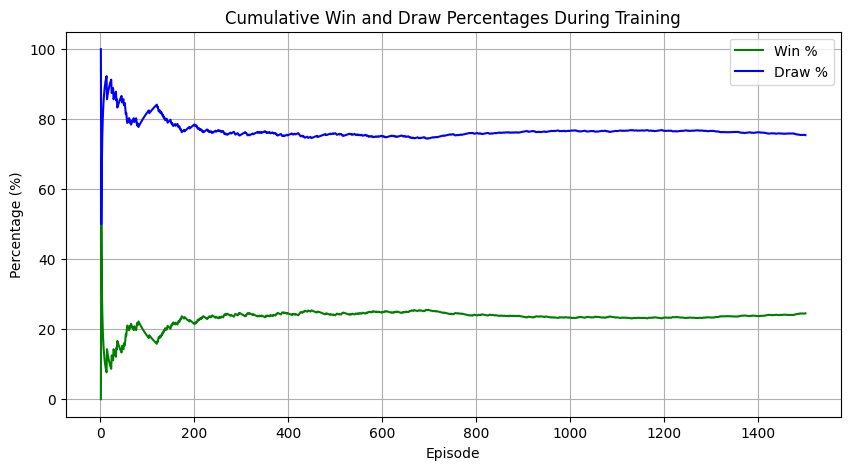

In [60]:
plot_win_draw(all_outcomes)


---

## 7. Visualization: Episode Reward During DQN Training

This function visualizes the **total reward per episode** collected during the training of the Deep Q-Network (DQN) agent.

### Details:
- X-axis: Episode number
- Y-axis: Total reward obtained in that episode
- Trends can indicate learning progress, reward shaping effectiveness, or instability.

Used to validate that the **agent is improving** over time and learning to avoid traps and seek bonus zones or wins.


In [62]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Total reward per episode', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Rewards')
    plt.grid(True)
    plt.legend()
    plt.show()


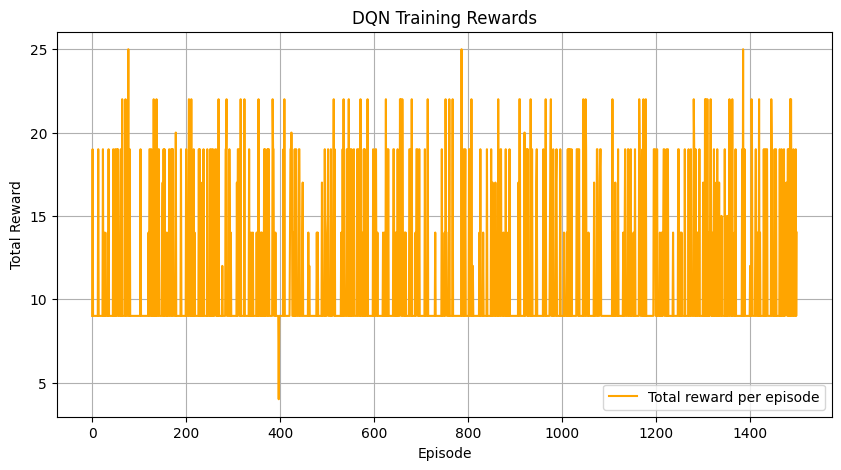

In [63]:
plot_rewards(all_rewards)


* Saving the trained model

In [50]:
import torch

torch.save(model.state_dict(), 'dqn_tictactoe_model.pt')
print("Model saved as dqn_tictactoe_model.pt")


Model saved as dqn_tictactoe_model.pt


---

## 8. Demonstration: Trained Agent Playing a Full Game

This function simulates a complete game where a trained agent (`model`) plays against itself in a single-agent rollout loop using the custom `TicTacToeEnv`.

### Highlights:
- The board is rendered after each move using ASCII-style formatting.
- The agent selects moves based on the highest Q-value using its trained policy.
- Only valid (unblocked & empty) cells are considered at each step.
- The function prints:
  - Game start state
  - Each move the agent makes
  - Final game state with the outcome (winner or draw)

This visualization helps validate that the trained agent follows legal moves and makes logical decisions within the rule-constrained environment.


In [52]:
def agent_play(model, env):
    def print_board(state):
        for row in state:
            print(' | '.join(row))
            print('-' * 17)

    state = env.reset()
    model.eval()
    done = False
    print("=== Game Start ===\n")
    print_board(state)

    while not done:
        encoded = torch.tensor(encode_state(state)).unsqueeze(0)
        with torch.no_grad():
            q_values = model(encoded)

        # Only choose valid actions
        valid_actions = [i for i in range(25) if env.board[i // 5][i % 5] == ' ']
        if not valid_actions:
            break

        action = max(valid_actions, key=lambda a: q_values[0][a].item())
        row, col = divmod(action, env.board_size)

        state, reward, done, info = env.step((row, col))

        print(f"\nAgent plays: ({row}, {col})")
        print_board(state)

        if done:
            print("\n🎯 Game Over")
            if "winner" in info and info["winner"]:
                print("🏆 Winner:", info["winner"])
            else:
                print("🤝 It's a draw")
        
        



In [53]:
agent_play(model, TicTacToeEnv())


=== Game Start ===

  |   |   |   |  
-----------------
* |   |   |   |  
-----------------
* |   |   |   |  
-----------------
  |   |   |   |  
-----------------
  |   | * |   |  
-----------------

Agent plays: (2, 3)
  |   |   |   |  
-----------------
* |   |   |   |  
-----------------
* |   |   | X |  
-----------------
  |   |   |   |  
-----------------
  |   | * |   |  
-----------------

Agent plays: (0, 2)
  |   | O |   |  
-----------------
* |   |   |   |  
-----------------
* |   |   | X |  
-----------------
  |   |   |   |  
-----------------
  |   | * |   |  
-----------------

Agent plays: (1, 4)
  |   | O |   |  
-----------------
* |   |   |   | △
-----------------
* |   |   | X |  
-----------------
  |   |   |   |  
-----------------
  |   | * |   |  
-----------------

Agent plays: (1, 2)
  |   | O |   |  
-----------------
* |   | X |   | △
-----------------
* |   |   | X |  
-----------------
  |   |   |   |  
-----------------
  |   | * |   |  
--------------

---

## 9. Results & Observations

- DQN agents learned effective strategies
- Power move use by agents works consistently
- Human interface allows full game playthrough
- Some bugs in second move power handling for human remain

---

## 10. Conclusion

The project demonstrates the application of Deep RL in a custom multi-agent game.
Future improvements:
- Fix power move click logic for humans
- Enhance UI for analytics and visualization
- Export replays or track player stats.

---